In [1]:
import pandas as pd
import networkx as nx
import pygraphviz as pgv
from shortest_path import SignedPathSolver
from pagerank import PageRankSolver
import time
from upsetplot import plot
from matplotlib import pyplot as plt
import os
import itertools
import numpy as np


## Shortest path

### Sign consistency

## Showcase with Trynska data

In [2]:
collectri = pd.read_csv('network_collectri.sif', sep='\t')
data_col = collectri.pop('data')
collectri.insert(2, 'data', data_col)
collectri.rename(columns={'source': '# source'}, inplace=True)
collectri.to_csv('collectri_network_sscp.sif', sep='\t', index=None)
collectri

,# source,target,data
0,CALM1,TRPC1,-1
1,CALM3,TRPC1,-1
2,CALM2,TRPC1,-1
3,CAV1,TRPC1,1
4,MDFI,TRPC1,-1
...,...,...,...
81749,NFKB,hsa-miR-143-3p,1
81750,AP1,hsa-miR-206,1
81751,NFKB,hsa-miR-21-5p,1
81752,NFKB,hsa-miR-224-5p,1


In [3]:
target_df = pd.read_csv('downstream_hits.tsv', sep='\t', header=None)
target_df.drop(1, inplace=True, axis=1)
target_df

,0,2
0,CINP,+
1,ATP1B1,+
2,DNAJC12,+
3,SCCPDH,+
4,IDS,+
...,...,...
95,IKZF1,-
96,SDHD,+
97,RASGRP3,+
98,BIRC6,-


In [4]:
target_df[2].replace({'+': 1, '-': -1}, inplace=True)

target_dict = target_df.set_index(0)[2].to_dict()


In [6]:
G = nx.read_weighted_edgelist('collectri_network_sscp.sif', delimiter = '\t', create_using = nx.DiGraph)

# 2. Iterate through each edge and 3. Set attributes
for u, v, data in G.edges(data=True):
    weight = data['weight']
    data['sign'] = 1 if weight >= 0 else -1
    data['weight'] = abs(weight)

G.get_edge_data('TGFB1', 'KLF2') #none

In [7]:
# Removes targets not present in the network
filtered_target_dict = {key: value for key, value in target_dict.items() if key in G.nodes()}

In [8]:
len(filtered_target_dict)

49

In [9]:
G_solver = SignedPathSolver(G)
G_solver.source_dict = {'TGFB1': 1, 'TGFB2': 1, 'TGFB3': 1, 'IL2': 1}
G_solver.target_dict = filtered_target_dict


## PageRank

In [10]:
P_solver = PageRankSolver(G)
P_solver.source_dict = {'TGFB1': 1, 'TGFB2': 1, 'TGFB3': 1, 'IL2': 1}
P_solver.target_dict = filtered_target_dict

In [11]:
P_solver.pagerank_solver(personalize_for='source')

In [12]:
P_solver.pagerank_solver(personalize_for='target')

In [142]:

threshold = 0.01
targets_from_paths = []
runinfo_dict = {}

# get non-pagerank solvers' info
start_time = time.time()
shortest_paths, runinfo = G_solver.shortest_paths(label = 'shortest_path')
end_time = time.time()
computation_time = end_time - start_time
runinfo_dict.update(runinfo)
runinfo_dict['shortest_path'].update({'computation_time': computation_time})
targets_from_paths = {path[-1] for path in G_solver.shortest_paths_res if len(path) > 1}
runinfo_dict['shortest_path'].update({'targets_connected': len(targets_from_paths)})
G_solver.visualize_graph("shortest_path", is_sign_consistent=False, export_sif=True)

start_time = time.time()
shortest_sc_paths, runinfo = G_solver.sign_consistency_check('shortest_sc_path')
end_time = time.time()
computation_time = end_time - start_time
runinfo_dict.update(runinfo)
runinfo_dict['shortest_sc_path'].update({'computation_time': computation_time})
targets_from_paths = {path[-1] for path in G_solver.shortest_sc_paths_res if len(path) > 1}
runinfo_dict['shortest_sc_path'].update({'targets_connected': len(targets_from_paths)})
G_solver.visualize_graph("shortest_sc_path", is_sign_consistent=True, export_sif=True)

while len(targets_from_paths) < len(filtered_target_dict)-3:
    
    P_solver.threshold = threshold
    threshold_label = f"pagerank_{threshold}"

    start_time = time.time()
    paths, runinfo = P_solver.compute_filtered_shortest_paths(label = threshold_label)
    end_time = time.time()

    targets_from_paths = {path[-1] for path in P_solver.shortest_paths_res if len(path) > 1}

    runinfo_dict.update(runinfo)

    runinfo_dict[threshold_label].update({'computation_time': computation_time})
    runinfo_dict[threshold_label].update({'targets_connected': len(targets_from_paths)})

    P_solver.visualize_pagerank(threshold_label, is_sign_consistent=False, export_sif=True)


    threshold_label = f"pagerank_sc_{threshold}"

    start_time = time.time()
    paths, runinfo = P_solver.sign_consistency_check(label = threshold_label)
    end_time = time.time()

    computation_time = end_time - start_time

    runinfo_dict.update(runinfo)
    runinfo_dict[threshold_label].update({'computation_time': computation_time})
    runinfo_dict[threshold_label].update({'targets_connected': len(targets_from_paths)})

    P_solver.visualize_pagerank(threshold_label, is_sign_consistent=True, export_sif=True)
    
    print(f"Threshold computed: {threshold}")

    threshold = round(threshold - 0.001, 3)


There were no sign consistent paths for the given perturbations and downstream effects.
Threshold computed: 0.01
Threshold computed: 0.009
Threshold computed: 0.008
Threshold computed: 0.007
Threshold computed: 0.006
Threshold computed: 0.005
Threshold computed: 0.004
Threshold computed: 0.003
Threshold computed: 0.002
Threshold computed: 0.001


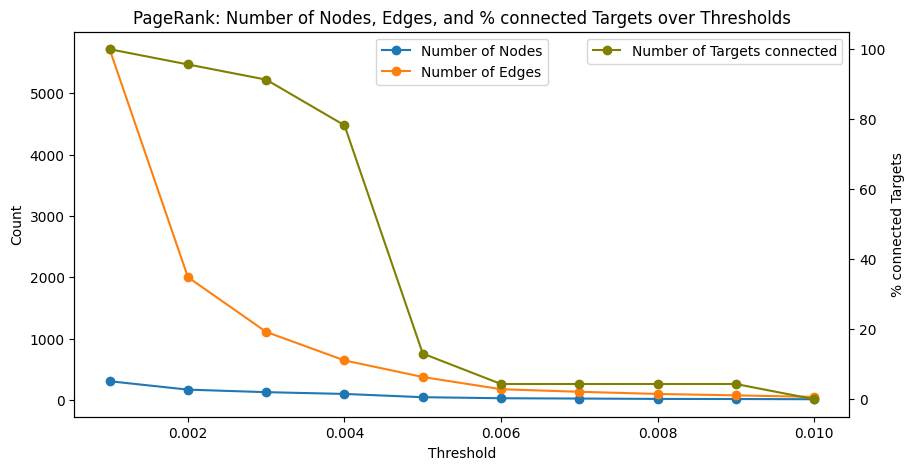

In [144]:
thresholds = list(runinfo_dict.keys())[2::2]
num_nodes = [runinfo_dict[t]['num_nodes'] for t in thresholds]
num_edges = [runinfo_dict[t]['num_edges'] for t in thresholds]
num_targets = [runinfo_dict[t]['targets_connected']/46*100 for t in thresholds]

thresholds_float = [float(t.split('_')[1]) for t in thresholds]

plt.figure(figsize=(10, 5))

# Primary y-axis (on the left)
ax1 = plt.gca()  # get the current axis
ax1.plot(thresholds_float, num_nodes, '-o', label="Number of Nodes")
ax1.plot(thresholds_float, num_edges, '-o', label="Number of Edges")
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Count')
ax1.tick_params(axis='y')
ax1.legend(loc='upper center')

# Secondary y-axis (on the right)
ax2 = ax1.twinx()  # Create a twin y-axis sharing the same x-axis
ax2.plot(thresholds_float, num_targets, '-o', label="Number of Targets connected", color='olive')
ax2.set_ylabel('% connected Targets')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('PageRank: Number of Nodes, Edges, and % connected Targets over Thresholds')
plt.show()


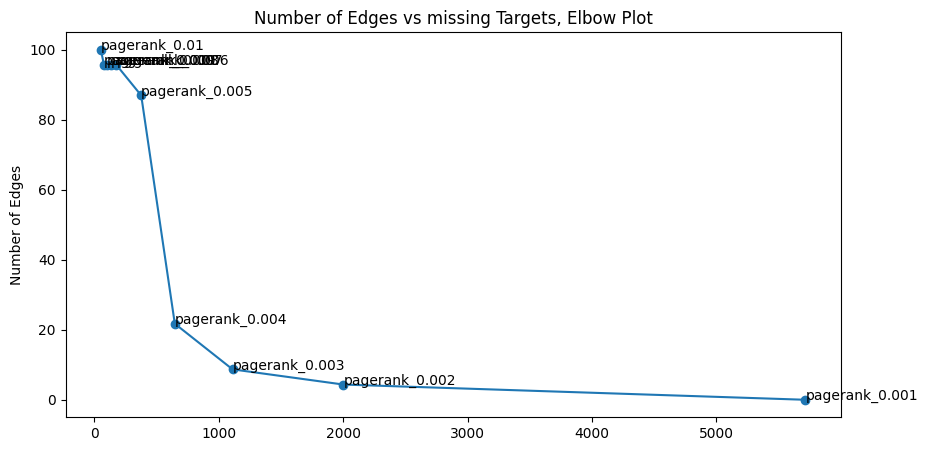

In [145]:
plt.figure(figsize=(10, 5))
ax = plt.gca()
missing_targets = [100-t for t in num_targets]
ax.plot(num_edges, missing_targets, '-o')
for t in thresholds:
    ax.text(num_edges[thresholds.index(t)], missing_targets[thresholds.index(t)], str(t))

plt.title('Number of Edges vs missing Targets, Elbow Plot')
plt.ylabel('% missing Targets')
plt.ylabel('Number of Edges')
plt.show()

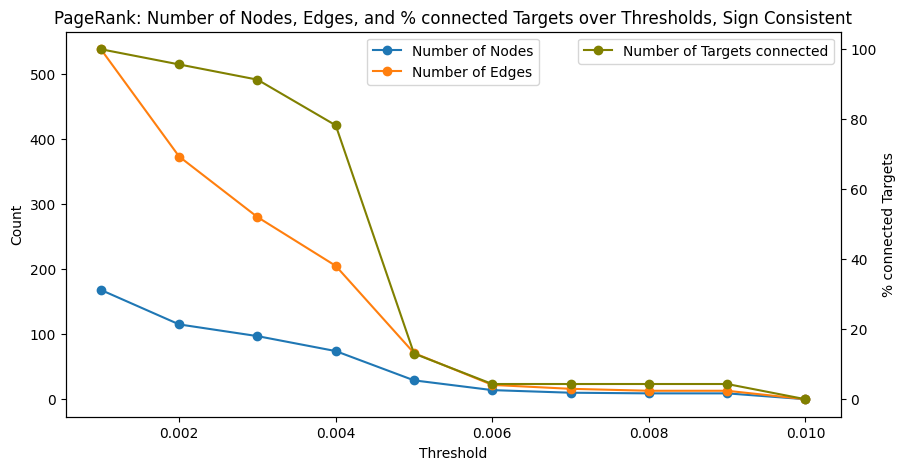

In [146]:
thresholds_sc = list(runinfo_dict.keys())[3::2]
num_nodes = [runinfo_dict[t]['num_nodes'] for t in thresholds_sc]
num_edges = [runinfo_dict[t]['num_edges'] for t in thresholds_sc]
num_targets = [runinfo_dict[t]['targets_connected']/46*100 for t in thresholds_sc]

thresholds_float = [float(t.split('_')[2]) for t in thresholds_sc]

plt.figure(figsize=(10, 5))

# Primary y-axis (on the left)
ax1 = plt.gca()  # get the current axis
ax1.plot(thresholds_float, num_nodes, '-o', label="Number of Nodes")
ax1.plot(thresholds_float, num_edges, '-o', label="Number of Edges")
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Count')
ax1.tick_params(axis='y')
ax1.legend(loc='upper center')

# Secondary y-axis (on the right)
ax2 = ax1.twinx()  # Create a twin y-axis sharing the same x-axis
ax2.plot(thresholds_float, num_targets, '-o', label="Number of Targets connected", color='olive')
ax2.set_ylabel('% connected Targets')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('PageRank: Number of Nodes, Edges, and % connected Targets over Thresholds, Sign Consistent')
plt.show()

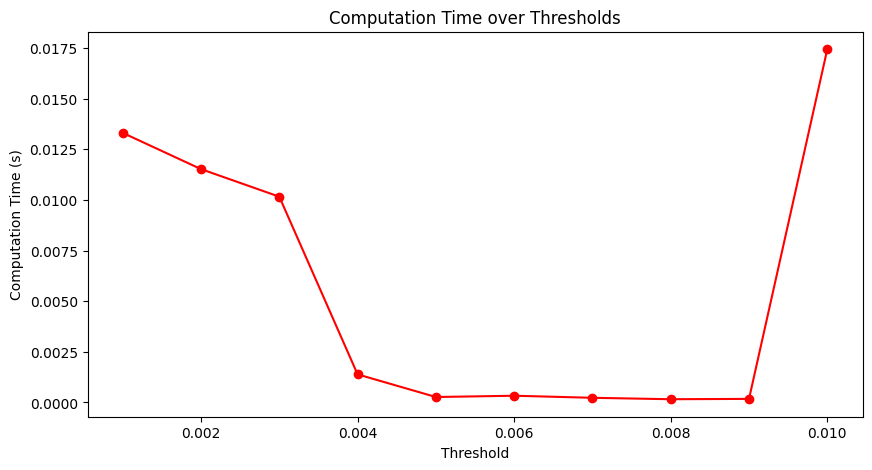

In [147]:

computation_times = [runinfo_dict[t]['computation_time'] for t in thresholds]
thresholds_float = [float(t.split('_')[1]) for t in thresholds]
plt.figure(figsize=(10, 5))
plt.plot(thresholds_float, computation_times, '-o', color="red")
plt.xlabel('Threshold')
plt.ylabel('Computation Time (s)')
plt.title('Computation Time over Thresholds')
plt.show()

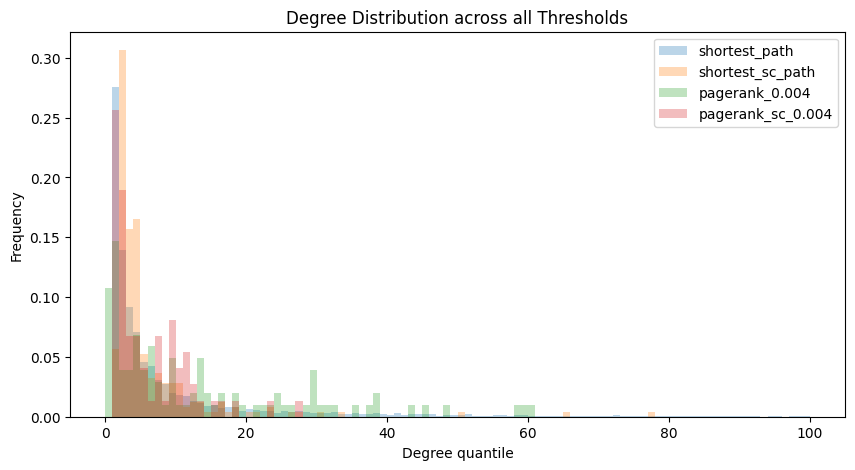

In [148]:


selected_thresholds = ['shortest_path', 'shortest_sc_path', 'pagerank_0.004', 'pagerank_sc_0.004']



plt.figure(figsize=(10, 5))
for threshold in selected_thresholds:
    data = runinfo_dict.get(threshold)  # Use `get` method to retrieve the data
    if data:  # This will check if data is not None
        norm_degrees = np.ones_like(data['degrees']) / len(data['degrees'])
        plt.hist(data['degrees'], label=threshold, alpha=0.3, bins=np.linspace(0, 100, 101), weights=norm_degrees)



plt.xlabel('Degree quantile')
plt.ylabel('Frequency')
plt.title('Degree Distribution across all Thresholds')
plt.legend(loc='upper right')
plt.show()


In [151]:
# Directory containing the sif files
directory = './'  # Change this to the path of your .sif files

is_sign_consistent = False

# Getting a list of all .sif files in the directory
expected_files = [threshold + ".sif" for threshold in selected_thresholds]
all_files = [f for f in os.listdir(directory) if f in expected_files]

# Parse the threshold from the filename
def get_threshold(filename):
    # Removing 'PageRank_' prefix and '.sif' suffix, then converting to float
    return filename.replace('.sif', '')

# Extracting edges from each file
edges_dict = {}
for file in all_files:
    path = os.path.join(directory, file)
    df = pd.read_csv(path, sep='\t')
    
    # Create unique edge representations
    edges = set(tuple(row) for index, row in df.iterrows())
    edges_dict[get_threshold(file)] = edges

# Creating a helper function to calculate intersection
def get_intersection_for_thresholds(thresholds):
    edge_sets = [edges_dict[thresh] for thresh in thresholds]
    return len(set.intersection(*edge_sets))

# This will generate the intersections and format the series as desired
intersection_dict = {}
for r in range(1, len(edges_dict.keys()) + 1):
    for combination in itertools.combinations(edges_dict.keys(), r):
        index_values = [threshold in combination for threshold in edges_dict.keys()]
        intersection_dict[tuple(index_values)] = get_intersection_for_thresholds(combination)


intersection_series = pd.Series(intersection_dict, )
intersection_series = intersection_series[intersection_series > 0]
intersection_series.index.names = combination


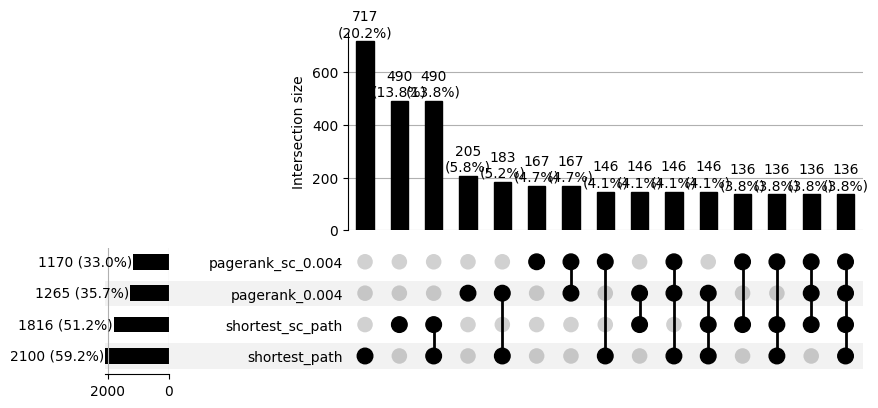

In [152]:



# Plot using upsetplot and use the created figure
plot(intersection_series, sort_by='cardinality', show_counts=True, show_percentages=True)
plt.show()

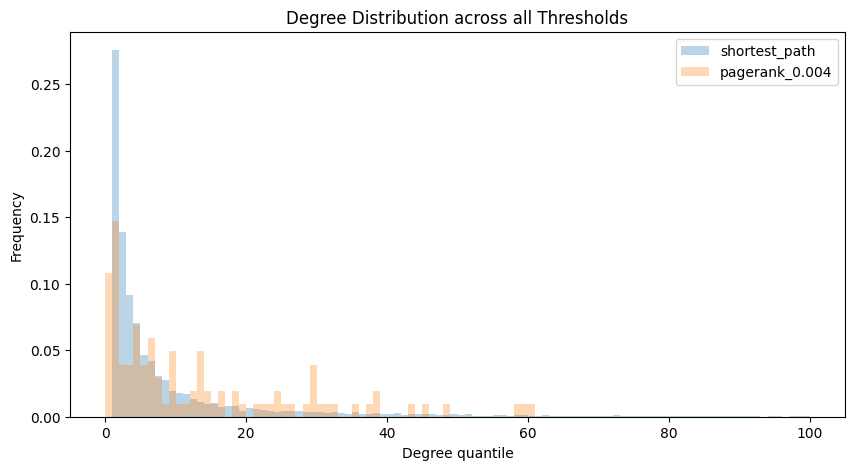

In [153]:
selected_thresholds = ['shortest_path', 'pagerank_0.004']



plt.figure(figsize=(10, 5))
for threshold in selected_thresholds:
    data = runinfo_dict.get(threshold)  # Use `get` method to retrieve the data
    if data:  # This will check if data is not None
        norm_degrees = np.ones_like(data['degrees']) / len(data['degrees'])
        plt.hist(data['degrees'], label=threshold, alpha=0.3, bins=np.linspace(0, 100, 101), weights=norm_degrees)



plt.xlabel('Degree quantile')
plt.ylabel('Frequency')
plt.title('Degree Distribution across all Thresholds')
plt.legend(loc='upper right')
plt.show()
